In [1]:
# Importing Required Libraries for Analysis and Modeling
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections import Counter 
from sklearn.feature_selection import RFECV
from scipy.stats import uniform, loguniform
from sklearn.metrics import roc_auc_score, confusion_matrix,fbeta_score,make_scorer, precision_recall_curve,average_precision_score,roc_curve,classification_report
import datetime
from pandas.tseries.offsets import DateOffset
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTENC
from scipy.sparse import hstack  
import pickle

In [2]:
# Set style for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
## Data Loading and Initial Inspection

df = pd.read_csv('loan_tap_dataset.csv')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.head(1))

   loan_amnt        term  int_rate  installment grade sub_grade  emp_title  \
0    10000.0   36 months     11.44       329.48     B        B4  Marketing   

  emp_length home_ownership  annual_inc verification_status   issue_d  \
0  10+ years           RENT    117000.0        Not Verified  Jan-2015   

  loan_status   purpose     title    dti earliest_cr_line  open_acc  pub_rec  \
0  Fully Paid  vacation  Vacation  26.24         Jun-1990      16.0      0.0   

   revol_bal  revol_util  total_acc initial_list_status application_type  \
0    36369.0        41.8       25.0                   w       INDIVIDUAL   

   mort_acc  pub_rec_bankruptcies  \
0       0.0                   0.0   

                                          address  
0  0174 Michelle Gateway\r\nMendozaberg, OK 22690  


# Logistic Regression Model

Splitting dataset for Training , Validation and Testing Logistic Regression Model

In [4]:
# Applying train test split before EDA. As its a imbalanced classification with stratification
X_train_validation, X_test, y_train_validation, y_test = train_test_split(df.drop(['loan_status'],axis = 1),df['loan_status'],random_state=40,test_size=0.2,stratify=df['loan_status'])

In [5]:
# Splitting into validation and training sets
X_train,X_validation,y_train,y_validation = train_test_split(X_train_validation,y_train_validation,random_state=40,test_size=0.2,stratify=y_train_validation)


In [6]:
# Checking shapes of datasets
print('X_train ',X_train.shape)
print('y_train ',y_train.shape)
print('X_validation ',X_validation.shape)
print('y_validation ',y_validation.shape)
print('X_test ',X_test.shape)
print('y_test ',y_test.shape)

X_train  (253459, 26)
y_train  (253459,)
X_validation  (63365, 26)
y_validation  (63365,)
X_test  (79206, 26)
y_test  (79206,)


## First Approach

* We will use one hot encode Zipcode , loan term , home ownership (after combining less frequent categories) , Verification Status , Employee Length (after binning) , Purpose (after grouping categories into family , small business and others).
* We will impute mortgage accounts and employment length using Annual income.
* We will impute revolving util with its median.
* We will use loan amount , interest rate , dti , mortgage accounts , open accounts , total accounts , revolving balance , revolving Utilization , Public Records as numerical features after capping the outliers.
* We will extract the quarter from  issue date and earliest credit date and convert into an ordinal feature.
* We will also use the month of issue date.
* We will create new features from loan title and employee title by extracting highest Frequency Rank among the words in each row, where the frequency is calculated over all rows in the columns.

### Preprocessing

In [7]:
# Label encoding on y_train - loan status
y_encoder = LabelEncoder( )
y_encoder.fit(y_train)
y_encoder.classes_= np.array(['Fully Paid','Charged Off'])
y_train_encoded = y_encoder.transform(y_train[X_train.index])

In [8]:
# Extracting Zipcode from address and applying one hot encoding
X_train_processed = pd.DataFrame(index = X_train.index)
zipcodes = X_train['address'].apply(lambda x : x.split()[-1]) 
zipcode_encoder = OneHotEncoder(drop='first')
zipcode_encoder.fit(pd.DataFrame(zipcodes))
X_train_processed[zipcode_encoder.get_feature_names_out()] = zipcode_encoder.transform(pd.DataFrame(zipcodes)).toarray()

In [9]:
# Applying one hot encoding on Loan term
term_encoder = OneHotEncoder(sparse_output=False,drop='first')
term_encoder.fit(pd.DataFrame(X_train['term']))
X_train_processed[term_encoder.get_feature_names_out()] = term_encoder.transform(X_train[['term']])

In [10]:
# Grouping home ownership into mortgage ,owned , rent , or others and applying ohe hot encoding
def home_ownership_cleanup(x):
    if x not in ['MORTGAGE','OWN','RENT']:
        return 'OTHERS'
    else:
        return x 
ho_encoder = OneHotEncoder(sparse_output=False,drop='first')
X_train_processed[ho_encoder.get_feature_names_out()] = ho_encoder.fit_transform(pd.DataFrame(X_train['home_ownership'].apply(home_ownership_cleanup)))

In [11]:
# Applying one hot encoding for verfication status
vs_encoder = OneHotEncoder(sparse_output=False,drop='first')
X_train_processed[vs_encoder.get_feature_names_out()] = vs_encoder.fit_transform(pd.DataFrame(X_train['verification_status']))

In [12]:
# converting employee length to numerical
def empl_length_num(x):
    if x!=x:
        return np.nan
    if x[:2]=='10':
        return 10
    if x[0]=='<':
        return 0
    else:
        return int(x[0])
# Imputing employee length using annual income
emp_len_imputer = KNNImputer(n_neighbors=1)
emp_length_imputed = emp_len_imputer.fit_transform(pd.DataFrame(X_train['emp_length'].apply(empl_length_num)),X_train['annual_inc'])


In [13]:
# Creating bins of employee length and applying one hot encoding
def emp_len_bin(x):
    
    if x < 1:
        return '<1 yr'
    if x < 1.5:
        return '1 yr'
    if 1.5 <= x < 7.5 :
        return '2-7 yrs'
    if 7.5 <= x < 9.5:
        return '8-9 yrs'
    if x >= 9.5 :
        return '10+ yrs'
emp_len_encoder = OneHotEncoder(sparse_output=False,drop='first')
X_train_processed[emp_len_encoder.get_feature_names_out()] = emp_len_encoder.fit_transform(pd.DataFrame(pd.Series(emp_length_imputed.reshape(1,-1)[0],index = X_train.index).apply(emp_len_bin)))
   

In [14]:
# Capping Loan amounts at 38000
X_train_processed['loan_amnt'] = X_train['loan_amnt'].clip(upper = 38000)

In [15]:
# Using interest rates as is
X_train_processed['int_rate'] = X_train['int_rate']

In [16]:
# Capping Open Accounts at 23
X_train_processed['open_acc'] = X_train['open_acc'].clip(upper=23)

In [17]:
# Capping Total Accounts at 54
X_train_processed['total_acc'] = X_train['total_acc'].clip(upper=54)

In [18]:
# Capping Annual Income at 150000
X_train_processed['annual_inc'] = X_train['annual_inc'].clip(upper=150000)

In [19]:
# Capping Revolving Balance at 40000
X_train_processed['revol_bal'] = X_train['revol_bal'].clip(upper = 40000)

In [20]:
# Capping Dti between 0 and 40
X_train_processed['dti'] = X_train['dti'].clip(lower = 0,upper = 40)

In [21]:
# Imputing Revolving Util with median and capping values at 129
revol_util_median = X_train['revol_util'].quantile(0.5)
revol_util_imputed = X_train['revol_util'].fillna(revol_util_median)
X_train_processed['revol_util'] = revol_util_imputed.clip(upper = 129)

In [22]:
# Grouping Purpose into Family , Small business and other and applying one hot encoding
purpose_encoder = OneHotEncoder(sparse_output=False,drop='first')
X_train_processed[purpose_encoder.get_feature_names_out()] = purpose_encoder.fit_transform(pd.DataFrame(X_train['purpose'].apply(lambda x : 'family' if x in ['credit_card','home_improvement','major_purchase','educational','wedding','car','vacation','house'] else ('other' if x!='small_business' else 'small_business'))
))

In [23]:
#  Getting the Issue date quarter converted to ordinal values and Issue date month 
X_train_processed['issue_qtr'] = (pd.to_datetime(X_train['issue_d'],format='%b-%Y')).dt.to_period('Q').apply(lambda x: x.ordinal)
X_train_processed['issue_month'] = pd.to_datetime(X_train['issue_d'],format = '%b-%Y').dt.month

In [24]:
# Imputing mort_acc using annual income 

mort_acc_imputer = KNNImputer(n_neighbors=1)
mort_acc_imputed = mort_acc_imputer.fit_transform(pd.DataFrame(X_train['mort_acc']),X_train['annual_inc']).round()


In [25]:
# Capping mort_acc at 7

X_train_processed['mort_acc'] = pd.Series(mort_acc_imputed.reshape(1,-1)[0],index = X_train.index).clip(upper = 7)

In [26]:
# Capping pub_rec at 1

X_train_processed['pub_rec'] = X_train['pub_rec'].clip(upper = 1)

In [27]:
# Getting the Earliest credit quarter converted to ordinal values 
X_train_processed['earliest_cr_qtr'] = (pd.to_datetime(X_train['earliest_cr_line'],format='%b-%Y')).dt.to_period('Q').apply(lambda x: x.ordinal)

In [28]:
# Creating a new feature from loan title - Frequency Rank of word in title column with highest frequency.
k = 1000
title_words_freq = pd.Series(Counter(' '.join(list(X_train['title'].dropna().apply(lambda x: x.lower()))).split())).sort_values(ascending=False)
title_word_rank = title_words_freq.iloc[:k].reset_index().reset_index().set_index('index')['level_0']
def title_check(x):
    z = [title_word_rank.get(i,k+1) for i in x.lower().split()]
    return min(z)
X_train_processed['title_word_rank'] = X_train['title'].fillna('debt').apply(title_check)

In [29]:
# Creating a new feature from lEmployee title - Frequency Rank of word in title column with highest frequency.
k = 1000
emp_title_words_freq = pd.Series(Counter(' '.join(list(X_train['emp_title'].fillna('missing').apply(lambda x: x.lower()))).split())).sort_values(ascending=False)
emp_title_word_rank = emp_title_words_freq.iloc[:k].reset_index().reset_index().set_index('index')['level_0']
def emp_title_check(x):
    z = [emp_title_word_rank.get(i,k+1) for i in x.lower().split()]
    return min(z)
X_train_processed['emp_title_word_rank'] = X_train['emp_title'].fillna('missing').apply(emp_title_check)

In [30]:
X_train_processed.columns

Index(['address_05113', 'address_11650', 'address_22690', 'address_29597',
       'address_30723', 'address_48052', 'address_70466', 'address_86630',
       'address_93700', 'term_ 60 months', 'home_ownership_OTHERS',
       'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Source Verified', 'verification_status_Verified',
       'x0_10+ yrs', 'x0_2-7 yrs', 'x0_8-9 yrs', 'x0_<1 yr', 'loan_amnt',
       'int_rate', 'open_acc', 'total_acc', 'annual_inc', 'revol_bal', 'dti',
       'revol_util', 'purpose_other', 'purpose_small_business', 'issue_qtr',
       'issue_month', 'mort_acc', 'pub_rec', 'earliest_cr_qtr',
       'title_word_rank', 'emp_title_word_rank'],
      dtype='object')

Excluding Grade , Sub grade to prevent multicollinearity because Interest rate seems to have been applied using sub grade .
Excluding Public recorded Bankruptices as its highly correlated with Public record which has no missing values
Excluding Initial List Status and Application Type as the association between them and loan status is very weak.
Excluding Installment to remove multicollinearity

In [31]:
# Appplying Standard Scaling of processed rows in training data
standard_scaler = StandardScaler()
X_train_processed_scaled = pd.DataFrame(standard_scaler.fit_transform(X_train_processed),columns = X_train_processed.columns)

In [32]:
# Checking if there  is multicollinearity 
corrv = X_train_processed_scaled.corr()
for i in corrv.columns:
    for j in corrv.columns:
        if i!=j:
            if corrv.loc[i,j]>0.5 or corrv.loc[i,j]<-0.5:
                print(i,j,corrv.loc[i,j])

verification_status_Source Verified verification_status_Verified -0.5197457748160222
verification_status_Verified verification_status_Source Verified -0.5197457748160222
x0_10+ yrs x0_2-7 yrs -0.6163511364185149
x0_2-7 yrs x0_10+ yrs -0.6163511364185149
open_acc total_acc 0.6795419199175577
total_acc open_acc 0.6795419199175577


The Correlations between features are reasonable.

In [33]:
# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_processed_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_processed_scaled, i) for i in range(X_train_processed_scaled.shape[1])]

print("\nVariance Inflation Factors:")
print(vif_data.sort_values('VIF', ascending=False))

problematic_features = vif_data[vif_data['VIF'] > 5]
print("\nProblematic Features (VIF > 5):")
print(problematic_features)


Variance Inflation Factors:
                                Feature       VIF
16                           x0_2-7 yrs  4.330441
15                           x0_10+ yrs  4.120511
22                            total_acc  2.384222
21                             open_acc  2.292430
17                           x0_8-9 yrs  2.138108
24                            revol_bal  2.102478
18                             x0_<1 yr  2.039260
6                         address_70466  1.917606
4                         address_30723  1.915232
2                         address_22690  1.911336
5                         address_48052  1.905472
19                            loan_amnt  1.884254
23                           annual_inc  1.862898
0                         address_05113  1.763802
3                         address_29597  1.759762
31                             mort_acc  1.631135
14         verification_status_Verified  1.614146
20                             int_rate  1.605579
26                   

THe Variation Inflation Factors of all features are within 5 indicating lack of Multicollinearity.

### Feature Selection using Recursive Feature Extraction

Fitting estimator with 36 features.
Fitting estimator with 35 features.
Optimal number of features: 34


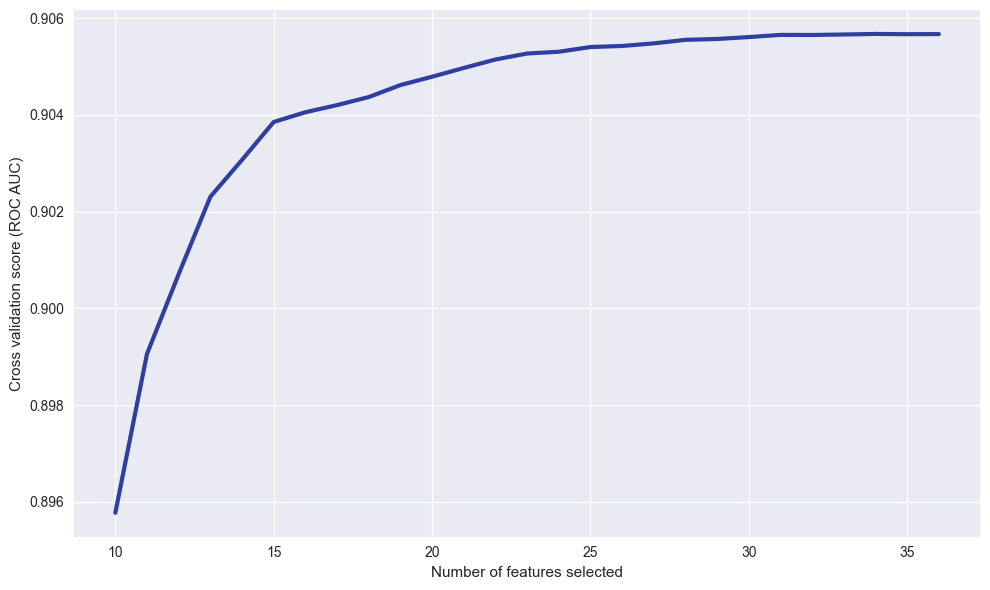

Selected features:
['address_05113', 'address_11650', 'address_22690', 'address_29597', 'address_30723', 'address_48052', 'address_70466', 'address_86630', 'address_93700', 'term_ 60 months', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Source Verified', 'verification_status_Verified', 'x0_10+ yrs', 'x0_2-7 yrs', 'x0_8-9 yrs', 'loan_amnt', 'int_rate', 'open_acc', 'total_acc', 'annual_inc', 'revol_bal', 'dti', 'revol_util', 'purpose_other', 'purpose_small_business', 'issue_qtr', 'issue_month', 'mort_acc', 'pub_rec', 'earliest_cr_qtr', 'title_word_rank', 'emp_title_word_rank']


In [34]:
# Applying RFECV Recursive Feature Extraction cross validation to select features with most predictive power
min_features_to_select=10 
cv = StratifiedKFold(5, shuffle=True, random_state=42)

# Initialize RFECV
rfecv = RFECV(
    estimator=LogisticRegression(max_iter=1000, class_weight='balanced'),
    n_jobs=-1,
    verbose=1,
    step=1,
    cv=cv,
    scoring='roc_auc',  # You can use other metrics like 'accuracy', 'f1', etc.
    min_features_to_select=10  # Minimum number of features to consider
)
# Fit RFECV
rfecv.fit(X_train_processed_scaled, y_train_encoded)

print(f"Optimal number of features: {rfecv.n_features_}")

# Plot number of features vs. cross-validation scores

plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (ROC AUC)")
plt.plot(range(min_features_to_select, len(rfecv.cv_results_["mean_test_score"]) + min_features_to_select), rfecv.cv_results_["mean_test_score"], color='#303F9F', linewidth=3)
plt.tight_layout()
plt.show()

# Get the selected features
selected_features = X_train_processed_scaled.columns[rfecv.support_]
print("Selected features:")
print(selected_features.tolist())

# Create final dataset with selected features
X_train_selected = X_train_processed_scaled[selected_features]

In [35]:
# Not selected Features
X_train_processed_scaled.columns[~rfecv.support_]

Index(['home_ownership_OTHERS', 'x0_<1 yr'], dtype='object')

Through Recursive  Feature extraction we can see that the maximum roc auc occurs when we use 34 of the 36 total features. There might be some redundant information in the the one hot encoded features of home ownership and emp length columns. We can remove these features ('home_ownership_OTHERS', 'emp_length_<1 yr')

The features left are zipcode , loan_term , home_ownership (OWN , RENT or others) , verification status , employee length (4 groups - <=1 , 2-7 , 8-9 , 10+) , loan amount , interest rate , open accounts , total accounts , annual income , revolving balance , dti , revolving util , purpose (small_busness , family and others) , issue date quarter , issue month , mortgage accounts , public records ,  earliest credit quarter , title word rank , employee title word rank . 

In [36]:
def preprocess(loan_data_t,default = None):
    loan_data = loan_data_t.copy()
    try:
        default_encoded = y_encoder.transform(default[loan_data.index])
    except:
        default_encoded = None
    loan_data_processed = pd.DataFrame(index = loan_data.index)
    zipcodes = loan_data['address'].apply(lambda x : x.split()[-1]) 
    loan_data_processed[zipcode_encoder.get_feature_names_out()] = zipcode_encoder.transform(pd.DataFrame(zipcodes)).toarray()

    loan_data_processed[term_encoder.get_feature_names_out()] = term_encoder.transform(loan_data[['term']])

    loan_data_processed[ho_encoder.get_feature_names_out()] = ho_encoder.transform(pd.DataFrame(loan_data['home_ownership'].apply(home_ownership_cleanup)))

    loan_data_processed[vs_encoder.get_feature_names_out()] = vs_encoder.transform(pd.DataFrame(loan_data['verification_status']))

    emp_length_imputed = emp_len_imputer.transform(pd.DataFrame(loan_data['emp_length'].apply(empl_length_num)))

    loan_data_processed[emp_len_encoder.get_feature_names_out()] = emp_len_encoder.transform(pd.DataFrame(pd.Series(emp_length_imputed.reshape(1,-1)[0],index = loan_data.index).apply(emp_len_bin)))
    
    loan_data_processed['loan_amnt'] = loan_data['loan_amnt'].clip(upper = 38000)
    loan_data_processed['int_rate'] = loan_data['int_rate']
    loan_data_processed['open_acc'] = loan_data['open_acc'].clip(upper=23)
    loan_data_processed['total_acc'] = loan_data['total_acc'].clip(upper=54)

    loan_data_processed['annual_inc'] = loan_data['annual_inc'].clip(upper=150000)

    loan_data_processed['revol_bal'] = pd.DataFrame(loan_data['revol_bal'].clip(upper = 40000))
    loan_data_processed['dti'] = loan_data['dti'].clip(lower = 0,upper = 40)

    loan_data_processed['revol_util'] = loan_data['revol_util'].fillna(revol_util_median).clip(upper = 129)

    loan_data_processed[purpose_encoder.get_feature_names_out()] = purpose_encoder.transform(pd.DataFrame(loan_data['purpose'].apply(lambda x : 'family' if x in ['credit_card','home_improvement','major_purchase','educational','wedding','car','vacation','house'] else ('other' if x!='small_business' else 'small_business'))
    ))

    loan_data_processed['issue_qtr'] = (pd.to_datetime(loan_data['issue_d'],format='%b-%Y')).dt.to_period('Q').apply(lambda x: x.ordinal)
    loan_data_processed['issue_month'] = pd.to_datetime(loan_data['issue_d'],format='%b-%Y').dt.month

    loan_data_processed['mort_acc'] = pd.Series(mort_acc_imputer.transform(pd.DataFrame(loan_data['mort_acc'])).reshape(1,-1)[0],index = loan_data.index).clip(upper = 7)

    loan_data_processed['pub_rec'] = loan_data['pub_rec'].clip(upper = 1)
    loan_data_processed['earliest_cr_qtr'] = (pd.to_datetime(loan_data['earliest_cr_line'],format='%b-%Y')).dt.to_period('Q').apply(lambda x: x.ordinal)

    loan_data_processed['title_word_rank'] = loan_data['title'].fillna('debt').apply(title_check)

    loan_data_processed['emp_title_word_rank'] = loan_data['emp_title'].fillna('missing').apply(emp_title_check)

    loan_data_processed_scaled = pd.DataFrame(standard_scaler.transform(loan_data_processed),columns = loan_data_processed.columns)
    loan_data_final = loan_data_processed_scaled[selected_features]
    return loan_data_final,default_encoded


In [37]:
# Applying preprocessing to Validation dataset
X_validation_final,y_validation_final = preprocess(X_validation,y_validation)

* We can choose performance metric precision vs recall importance based on average cost ,loss and profit.

In [38]:
average_cost = df['loan_amnt'].mean()
average_profit_if_not_default = ((df['installment'])*(df['term'].apply(lambda x: int(x[:3])))*(df['loan_status'].map({'Charged Off':0,'Fully Paid':1})) - df['loan_amnt']*(df['loan_status'].map({'Charged Off':0,'Fully Paid':1}))).sum()/df['loan_status'].map({'Charged Off':0,'Fully Paid':1}).sum()
average_loss_if_default = (df['loan_amnt']*(df['loan_status'].map({'Charged Off':1,'Fully Paid':0}))).sum()/(df['loan_status'].map({'Charged Off':1,'Fully Paid':0})).sum()
print("Average Cost of a Loan", average_cost)
print("Average Loss if the loan is defaulted",average_loss_if_default)
print("Average Profit if the loan is not defaulted",average_profit_if_not_default)

Average Cost of a Loan 14113.888089286165
Average Loss if the loan is defaulted 15126.300966873945
Average Profit if the loan is not defaulted 3885.992099309894


Based on the we can see that false negatives are ~4 times (15126/3886) more impactful than false positives.
We can use f-beta score as the performance metric with beta = 2 (√4)

We  will cross validate on different hyperparameters - regularization penalties (l1 , l2 , elastic net) ,regularization parameters (C , l_1 ratio).
We will also use Stratified KFold and search over multiple class weights for handling class imbalance

### Model Selection using RandomizedSearchCV

In [39]:
param_distributions = [
    # For liblinear solver
    {
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'C': loguniform(1e-4, 1e3),
        'class_weight': ['balanced', None, {0:1, 1:3},{0:1,1:4}, {0:1, 1:5},{0:1,1:8}]
    },
    # For saga solver (supports all penalties)
    {
        'solver': ['saga'],
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'C': loguniform(1e-4, 1e3),
        'l1_ratio': uniform(0, 1), 
        'class_weight': ['balanced', None, {0:1, 1:3},{0:1,1:4}, {0:1, 1:5},{0:1,1:8}]
    },
    # For lbfgs solver
    {
        'solver': ['lbfgs'],
        'penalty': ['l2', None],
        'C': loguniform(1e-4, 1e3),
        'class_weight': ['balanced', None, {0:1, 1:3},{0:1,1:4}, {0:1, 1:5},{0:1,1:8}]
    }
]

# Stratified K Fold for handling class imbalance
cv = StratifiedKFold(n_splits=4, shuffle=True,random_state=42)

# Create model
model = LogisticRegression(random_state=42, max_iter=1000)

# Set up Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    random_state=42,
    n_iter=12,
    cv=cv,
    scoring=make_scorer(fbeta_score,beta = 2), 
    verbose=3,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train_selected, y_train_encoded)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


c:\Users\sanju\Downloads\Project_work\LoanTapAnalysis\LoanTapDataAnalysis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=LogisticRegression(max_iter=1000, random_state=42),
                   n_iter=12, n_jobs=-1,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002B0AF482BD0>,
                                         'class_weight': ['balanced', None,
                                                          {0: 1, 1: 3},
                                                          {0: 1, 1: 4},
                                                          {0: 1, 1: 5},
                                                          {0: 1, 1: 8}],
                                         'penalty'...
                                         'penalty': ['l1', 'l2', 'elasticnet',
                                                     None],
                                         'solver': ['saga']},
                                        {'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002B0AF482300>,
                                         'class_weight': ['balanced', None,
                                                          {0: 1, 1: 3},
                                                          {0: 1, 1: 4},
                                                          {0: 1, 1: 5},
                                                          {0: 1, 1: 8}],
                                         'penalty': ['l2', None],
                                         'solver': ['lbfgs']}],
                   random_state=42,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
                   verbose=3)

### Model Evaluation

Best Parameters:
{'C': np.float64(0.00025502648504032837), 'class_weight': {0: 1, 1: 5}, 'penalty': None, 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.7247

Test Set Performance Metrics:
              precision    recall  f1-score   support

           0       0.95      0.75      0.84     50937
           1       0.45      0.85      0.59     12428

    accuracy                           0.77     63365
   macro avg       0.70      0.80      0.71     63365
weighted avg       0.85      0.77      0.79     63365

Confusion Matrix:
[[38053 12884]
 [ 1896 10532]]
ROC AUC: 0.9045
PR AUC: 0.7775
F beta Score (beta=2): 0.7201

Top 5 Models:
Rank 1: Score = 0.7247, Params = {'C': 0.00025502648504032837, 'class_weight': {0: 1, 1: 5}, 'solver': 'lbfgs'}
Rank 2: Score = 0.7246, Params = {'C': 1.7898389848671583, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l1', 'solver': 'liblinear'}
Rank 3: Score = 0.7220, Params = {'C': 0.15577217702693022, 'class_weight': {0: 1, 1: 8}, 'penalty': 'l2', 'solver'

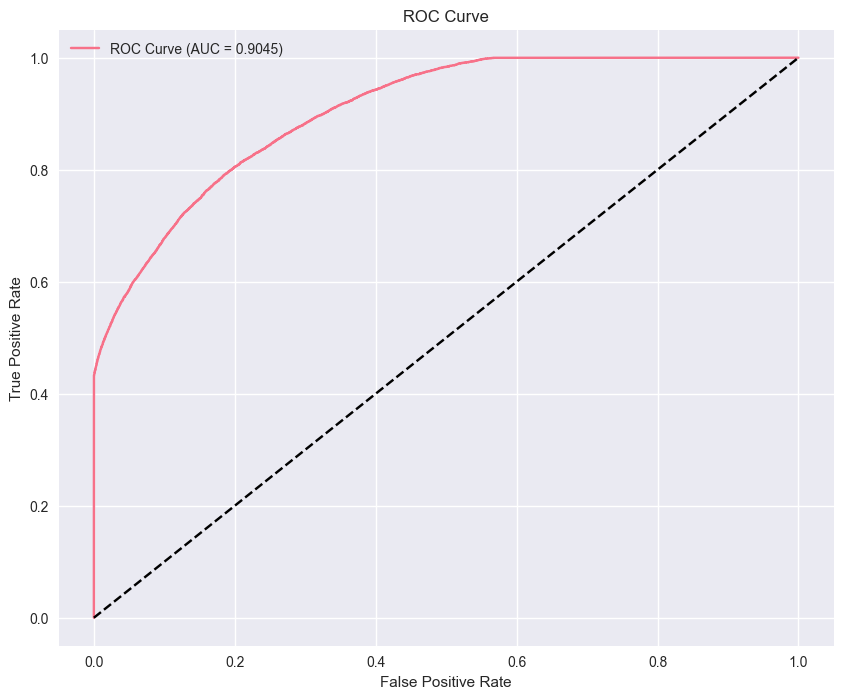

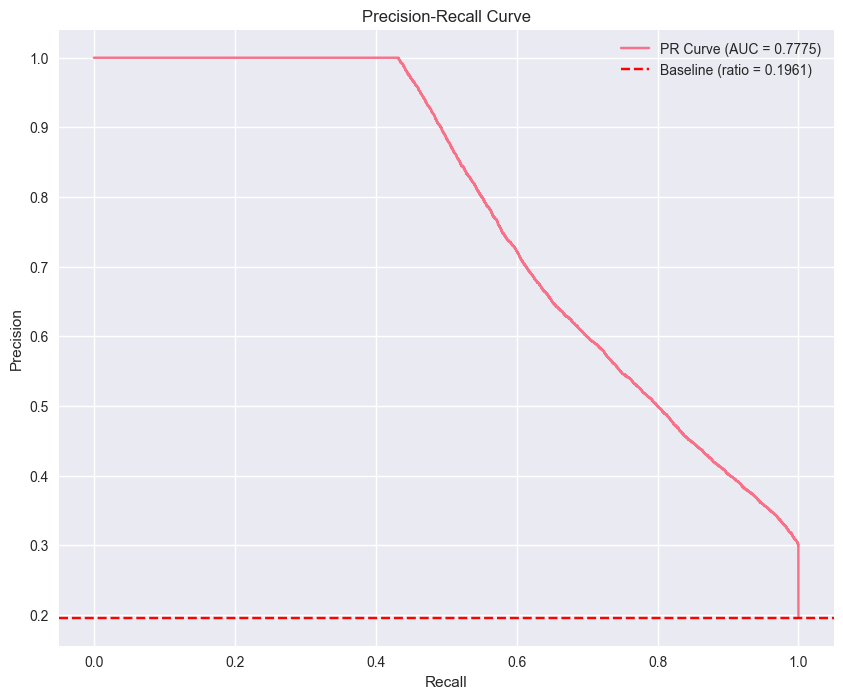


Optimal Threshold (based on F beta score): 0.4545

Performance at Optimal Threshold:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     50937
           1       0.41      0.89      0.56     12428

    accuracy                           0.73     63365
   macro avg       0.69      0.79      0.68     63365
weighted avg       0.85      0.73      0.76     63365

Final F Beta Score :  0.7222817984463683
Final PR-AUC Score :  0.7774630602842929
Final ROC-AUC Score :  0.9044802998818555


In [40]:
def evaluate_best_model(random_search, X_test, y_test):
    # Get the best estimator from random search
    best_model = random_search.best_estimator_
    
    # Get predicted probabilities and binary predictions
    y_pred_proba = best_model.predict_proba(X_test)[:,1]
    y_pred = best_model.predict(X_test)
    
    # Print best parameters
    print("Best Parameters:")
    print(random_search.best_params_)
    print(f"Best Cross-Validation Score: {random_search.best_score_:.4f}")
    
    # Calculate metrics
    print("\nTest Set Performance Metrics:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # PR AUC 
    pr_auc = average_precision_score(y_test, y_pred_proba)
    print(f"PR AUC: {pr_auc:.4f}")
    
    # F beta Score
    fb_s = fbeta_score(y_test, y_pred,beta=2)
    print(f"F beta Score (beta=2): {fb_s:.4f}")

    cv_results = pd.DataFrame(random_search.cv_results_)
    
    # Display top 5 models
    top_results = cv_results.sort_values('rank_test_score').head()
    print("\nTop 5 Models:")
    for i, row in top_results.iterrows():
        params = {k.replace('param_', ''): v for k, v in row.items() if k.startswith('param_') and not pd.isna(v)}
        print(f"Rank {row['rank_test_score']}: Score = {row['mean_test_score']:.4f}, Params = {params}")
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')
    # Add baseline for PR curve (class distribution)
    baseline = np.sum(y_test) / len(y_test)
    plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline (ratio = {baseline:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    
    # Find optimal threshold (F1 score)
    thresholds = np.linspace(0, 1, 100)
    fb_scores = []
    for threshold in thresholds:
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)
        fb = fbeta_score(y_test, y_pred_threshold,beta=2)
        fb_scores.append(fb)
    
    best_threshold_idx = np.argmax(fb_scores)
    best_threshold = thresholds[best_threshold_idx]
    print(f"\nOptimal Threshold (based on F beta score): {best_threshold:.4f}")
    
    # Performance at optimal threshold
    y_pred_optimal = (y_pred_proba >= best_threshold).astype(int)
    print("\nPerformance at Optimal Threshold:")
    print(classification_report(y_test, y_pred_optimal))
    print("Final F Beta Score : ",fbeta_score(y_test, y_pred_optimal,beta=2))
    print("Final PR-AUC Score : ",average_precision_score(y_test, y_pred_proba))
    print("Final ROC-AUC Score : ",roc_auc_score(y_test, y_pred_proba))
    return best_model, best_threshold

# Call the function with your random search results
best_model, optimal_threshold = evaluate_best_model(random_search ,  X_validation_final, y_validation_final)

### Model Performance Analysis
* The f beta score is 0.722 at a threshold of 0.4545.
* The recall for loan default is 0.89 at that threshold which is very high.
*  As the Precision for loan default at optimum threshold is 0.41, which means there will be some missed opportunities.
*  High ROC - AUC 0.9045 indicates good seperation between default and non default loans.
*  The best model uses l2 regularization with very low C indicating high l2 regularization. 
* The class weights are 1:5 - non loan default : loan default,  indicating more weight needed for defaulted loans than the imbalance ratio of 1:4 in favor of non default loans.

In [41]:
# Coefficients of features in the final model and their Permutation importance 
model_coefficients = pd.DataFrame(index = X_train_selected.columns ,columns = ['coefficents','abs_values_coefficients'], data = np.transpose([random_search.best_estimator_.coef_[0],abs(random_search.best_estimator_.coef_[0])]))
print("Coefficients : ",'\n' ,model_coefficients.sort_values(by = 'abs_values_coefficients',axis = 0,ascending=False))
feature_imp = permutation_importance(random_search.best_estimator_,X_validation_final,y_validation_final,n_repeats=10,random_state=42)
print("Permutation Importance : ",'\n', pd.Series(data = abs(feature_imp['importances_mean']),index = X_validation_final.columns).sort_values(ascending=False))

Coefficients :  
                                      coefficents  abs_values_coefficients
address_93700                           4.162885                 4.162885
address_11650                           4.157005                 4.157005
address_86630                           4.104784                 4.104784
address_70466                           3.780786                 3.780786
address_30723                           3.772934                 3.772934
address_48052                           3.769998                 3.769998
address_22690                           3.762337                 3.762337
address_05113                          -3.007123                 3.007123
address_29597                          -2.995200                 2.995200
int_rate                                0.447415                 0.447415
term_ 60 months                         0.204709                 0.204709
annual_inc                             -0.204571                 0.204571
dti                 

### Features Insights Based on the Model coefficients and Permutation importance :
*  Zipcodes : The most important features contributing to model performance is Zipcodes which is not ideal in terms of data bias. 3 zipcodes seem to have only defaulted loans. 3 of them have only fully paid loans. rest of the 4 have approximately 1:4 ratio of default to fully paid loans
*  Interest Rate : After zipcode, interest rate is the most important parameter which contributes most to prediction. 
*  Term and Loan Amount : Loan parameters like amount and term come next in terms of default prediction.
*  Loanee profile : Loanee profile parameters like Debt to Income , No of open accounts , Annual Income , Home ownersip , Revolving Utilization , Total Accounts , Verification Status , Mortgage Accounts , Revolving balance , Public records , Earliest credit Quarter , Issue month aldo contribute to default prediction in that order.
*  Loan parameters like Issue Quarter and Purpose especially is its small business are also significant.

We will create a  baseline  loan profile and compute its loan default probability using our model.

In [42]:
def empl_string(x):
    if x == 0 :
        return '<1 year'
    elif x == 1 :
        return '1 year'
    elif 1 <=x <= 9:
        return str(int(x)) + ' years'
    else:
        return '10+ years'    

df_baseline = df.loc[:,['loan_amnt', 'term', 'int_rate',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'purpose', 'title', 'dti',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'mort_acc', 'address']].dropna()
df_baseline['address'] = df_baseline['address'].apply(lambda x : x.split()[-1]) 
df_baseline['emp_length'] = df_baseline['emp_length'].apply(empl_length_num)
df_baseline.loc[:,['term','emp_title', 'emp_length', 'home_ownership',
       'verification_status','purpose', 'title','address']].mode()
baseline_loan = pd.concat([df_baseline.loc[:,['term','emp_title','home_ownership',
       'verification_status','purpose', 'title','address']].mode().loc[0],df_baseline.loc[:,['loan_amnt','int_rate','annual_inc','dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'mort_acc','emp_length']].quantile(0.5)])
baseline_loan['emp_length'] = empl_string(baseline_loan['emp_length'])
baseline_loan['issue_d']  = (datetime.datetime.today() + (pd.to_datetime(df_baseline['issue_d'],format = '%b-%Y') - datetime.datetime.today() ).quantile(0.5)).strftime("%b-%Y")
baseline_loan['earliest_cr_line'] = (pd.to_datetime(baseline_loan['issue_d'],format = '%b-%Y') - (pd.to_datetime(df_baseline['issue_d'],format = '%b-%Y') - pd.to_datetime(df_baseline['earliest_cr_line'],format = '%b-%Y') ).quantile(0.5)).strftime("%b-%Y")
best_model = random_search.best_estimator_
baseline_prob  = best_model.predict_proba(preprocess(pd.DataFrame(data = [baseline_loan.values],columns = baseline_loan.index))[0])[0][1]
print("Baseline Loan : ",baseline_loan)
print("Baseline Probability : ",baseline_prob)
df_baseline['emp_length'] = df_baseline['emp_length'].apply(empl_string)

Baseline Loan :  term                            36 months
emp_title                         Teacher
home_ownership                   MORTGAGE
verification_status       Source Verified
purpose                debt_consolidation
title                  Debt consolidation
address                             70466
loan_amnt                         12400.0
int_rate                            13.35
annual_inc                        65000.0
dti                                 17.25
open_acc                             11.0
pub_rec                               0.0
revol_bal                         11480.0
revol_util                           55.3
total_acc                            24.0
mort_acc                              1.0
emp_length                        6 years
issue_d                          May-2014
earliest_cr_line                 Dec-1999
dtype: object
Baseline Probability :  0.4895033648048189


The baseline loan profile has a computed loan default probability of 0.49. 
We will take changes in the features and calculate new probability for each feature and compute the marginal effect of change in each feature on loan default probability.

                                       Feature Change  Probability Change  \
49                               address: 70466→93700            0.510496   
44                               address: 70466→11650            0.510496   
48                               address: 70466→86630            0.510496   
42                               address: 70466→05113           -0.489503   
46                               address: 70466→29597           -0.489503   
43                               address: 70466→00813           -0.489484   
31         purpose: debt_consolidation→small_business            0.128618   
20                        term:  36 months→ 60 months            0.118622   
5                                 annual_inc (-65000)            0.098150   
4                                 annual_inc (+65000)           -0.097348   
6                                           dti (+17)            0.093564   
7                                           dti (-17)           -0.092834   

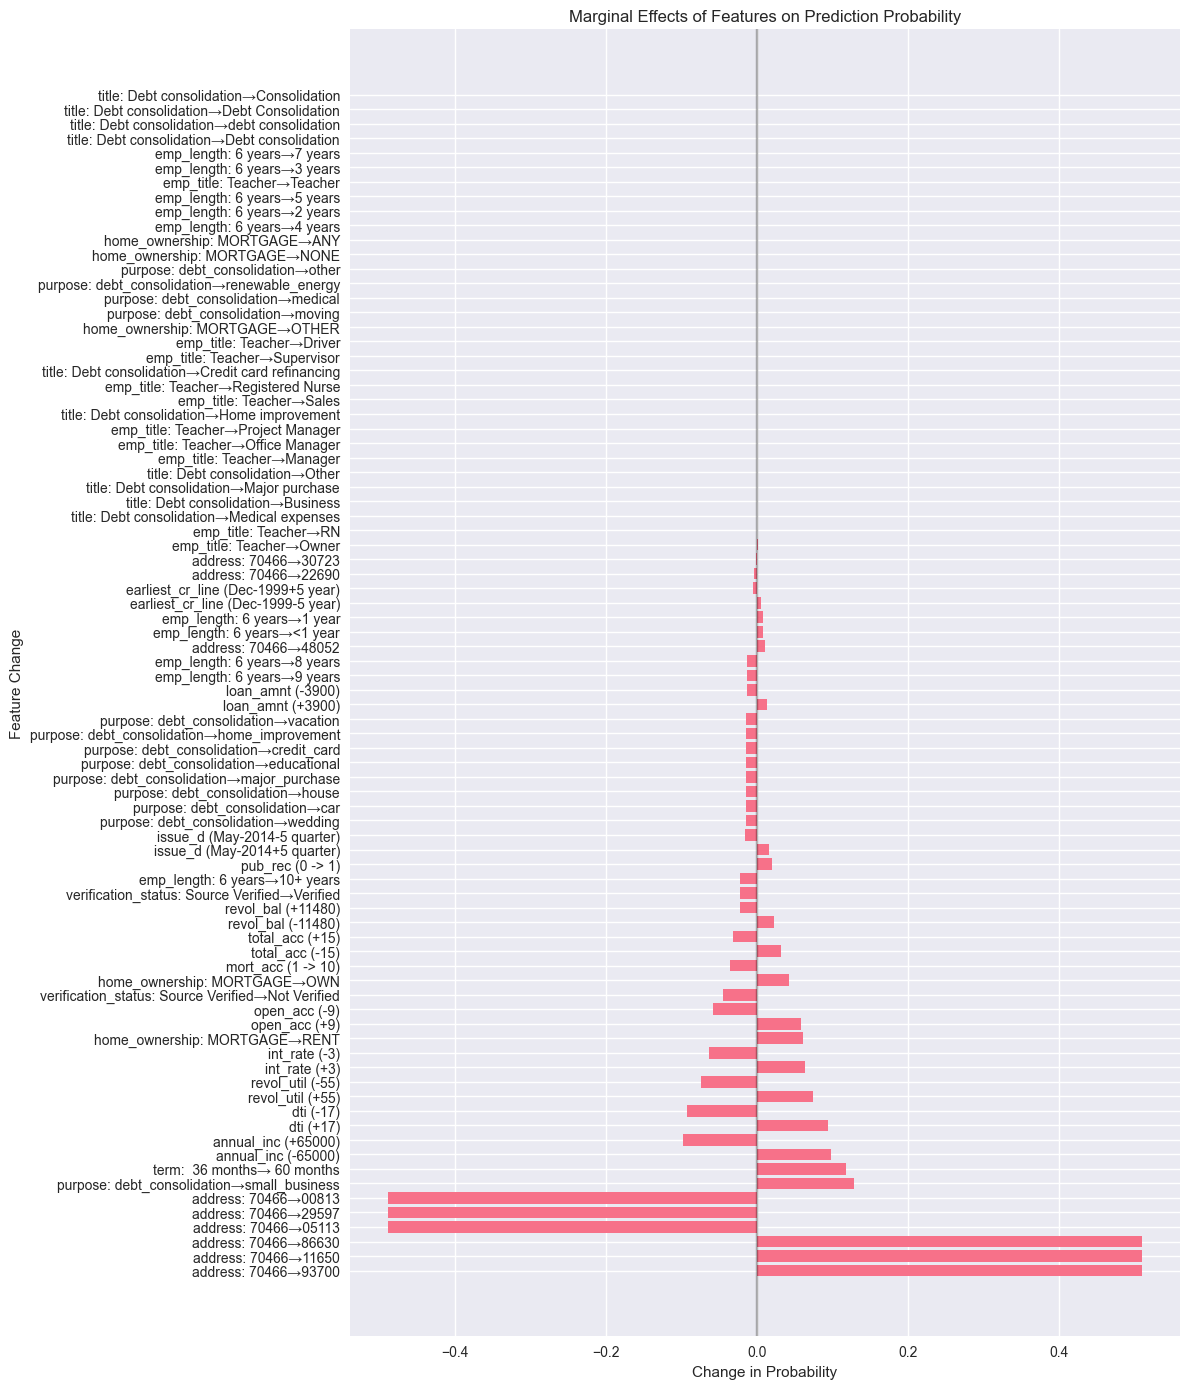

In [43]:

marginal_effects = {}

continuous_features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_bal',  'revol_util', 'open_acc', 'total_acc']
continuous_changes = {i:0.1*(df_baseline[i].max()-df_baseline[i].min()) for i in continuous_features}
continuous_changes['earliest_cr_line'] = 5 # 1 year change in earliest credit date 
continuous_changes['issue_d'] = 5 # 1 quarter change in  issue date
for feature, change in continuous_changes.items():
    # Create modified profile with increased feature value

    modified = baseline_loan.copy()
    if feature == 'earliest_cr_line':
        change_text = '5 year'
        modified[feature] = pd.to_datetime(baseline_loan[feature],format = '%b-%Y') + DateOffset(months = change*12)
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} ({baseline_loan['earliest_cr_line']}+{change_text})"] = modified_prob - baseline_prob
        modified[feature] = pd.to_datetime(baseline_loan[feature],format = '%b-%Y') - DateOffset(months = change*12)
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} ({baseline_loan['earliest_cr_line']}-{change_text})"] = modified_prob - baseline_prob
    elif feature == 'issue_d':
        change_text = '5 quarter' 
        modified[feature] = pd.to_datetime(baseline_loan[feature],format = '%b-%Y') + DateOffset(months = change*3)
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} ({baseline_loan['issue_d']}+{change_text})"] = modified_prob - baseline_prob
        modified[feature] = pd.to_datetime(baseline_loan[feature],format = '%b-%Y') - DateOffset(months = change*3)
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} ({baseline_loan['issue_d']}-{change_text})"] = modified_prob - baseline_prob
    else:
        change = min(baseline_loan[feature],change)
        change_text = f"{change:.0f}"
        modified[feature] = baseline_loan[feature] + change
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} (+{change_text})"] = modified_prob - baseline_prob
        modified[feature] = baseline_loan[feature] - change
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} (-{change_text})"] = modified_prob - baseline_prob

# For categorical variables - compare to reference level
categorical_features = ['term','home_ownership', 'verification_status', 'purpose','address','emp_length']

for feature in categorical_features:
    # Get current value in baseline
    reference_value = baseline_loan[feature]
    
    # Get all possible values for this feature (excluding reference)
    possible_values = [v for v in df_baseline[feature].unique() if v != reference_value]
    
    for value in possible_values:
        # Create modified profile with new category
        modified = baseline_loan.copy()
        modified[feature] = value
        
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
    
        marginal_effects[f"{feature}: {reference_value}→{value}"] = modified_prob - baseline_prob
for emp_name in df_baseline['emp_title'].value_counts().iloc[:10].keys():
    # Create modified profile with new category
    modified = baseline_loan.copy()
    modified['emp_title'] = emp_name
    
    modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]

    marginal_effects[f"emp_title: {baseline_loan['emp_title']}→{emp_name}"] = modified_prob - baseline_prob
for loan_title in df_baseline['title'].value_counts().iloc[:10].keys():
    # Create modified profile with new category
    modified = baseline_loan.copy()
    modified['title'] = loan_title
    
    modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]

    marginal_effects[f"title: {baseline_loan['title']}→{loan_title}"] = modified_prob - baseline_prob

modified = baseline_loan.copy()
modified['pub_rec'] = 1
modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
marginal_effects[f"pub_rec (0 -> 1)"] = modified_prob - baseline_prob

modified = baseline_loan.copy()
modified['mort_acc'] = 10
modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
marginal_effects[f"mort_acc (1 -> 10)"] = modified_prob - baseline_prob

# Convert to DataFrame for easier handling
effects_df = pd.DataFrame(marginal_effects.items(), columns=['Feature Change', 'Probability Change'])

# Sort by absolute effect size
effects_df['Abs Effect'] = effects_df['Probability Change'].abs()
effects_df = effects_df.sort_values('Abs Effect', ascending=False)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(effects_df)

# Plot
plt.figure(figsize=(12,14))
plt.barh(effects_df['Feature Change'], effects_df['Probability Change'])
plt.xlabel('Change in Probability')
plt.ylabel('Feature Change')
plt.title('Marginal Effects of Features on Prediction Probability')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

 ### Marginal effects of features:
 *   Change in Zipcode to pure loan default or non loan default zipcodes causes major change in probabiliies (~50%).
 *   Changing the Loan Purpose to Small Business from debt consolidation causes  increase in default probability by 13%
 *   Increasing Loan term from 36 months to 60 months increases loan default probability by 12%
 *   Increasing Annual Income by 65000 from 65000  decreases the loan default probability by 10% and vice versa.
 *   Increasing dti ratio from 17 to 34 increases loan default probability by 10% and decreasing it to 0 decreases loan default probability by 10%
 *   Increasing revolving utilization from 55 to 110 % increases loan default probability by 7.5%.
 *   Increasing interest rate from 13 to 3 % increased loan default probability by 6.4% and decreases by same amount when it decreases from 13 to 10%.
 *   Changing Home ownership from mortgage to rent increases loan default probability by 6 %.
 *   Increasing open accounts from 11 to 20 increases loan default probability by 6%.
 *   Changing Verification Status from Source Verified to Not Verified  increases loan default probability by 4.5%.
 *   Changing Home ownership from mortgage to own increases loan default probability by 4 %.
 *  Increasing number of mortgage accounts from 1 to 10 decreases probabilityt by 3.5%.
 *   Increasing total accounts from 24 to 39 decreases loan default probability by 3%.
 *   Doubling Revolving Balance from 11480 to 22960 decreases loan default probability by 2%.
 *  Increasing loan amount from 12400 to 16000 increases loan default probability by 1.3%
 *   Changing Verification Status from Source Verified to fully verified  decreases loan default probability by 2.2%.
 *   Changing employment length from 6 years to 10+ years causes loan default probability to reduce by 2.1%
 *   Changing Purpose of loan from debt consolidation to Family purpose like wedding , house , home improvement ,car, credit card, educational , major purchase and vacation,  decreases loan default probability by 1.3%.
  *   Changing employment length from 6 years to 8,9 years causes loan default probability to reduce by 1.25%
  *  If there are public records for the loanee the loan default probability increases by 2%.
  *  If the loan was issued 5 quarters before May 2014 the loan default probability decreases by 1.6% and vice versa.
 * Features like issue date , earliest credit line, title , employee title dont contribute much to predicting loan default probability in the current model.

We willl try a different configuration of features and preprocessing and apply Logistic Regression again.

## Second Approach

* In this approach ww will try different preprocessing , use pub_rec_bankruptcies instead of pub_rec, sub_grade instead of interest rate, create interaction features- income to loan amount ratio , and open acc to total account ratio.
* We will use one hot encode Zipcode , loan term , home ownership (different grouping from previous approach) , Verification Status , Purpose (after grouping categories into debt consolidation , major purchase and using other categories as is), employee title (after extracting top 10 employee titles and grouping rest as others)
* We will impute mortgage accounts and employment length using Annual income.
* We will impute revolving util with its median.
* We will impute pub_rec_bankruptices using pub_rec as they are highly correlated. 
* We will bin loan amount , employment length , dti , mortgage accounts , total accounts , revolving Utilization , Public Bankruptcies,mortgage accounts and convert them to ordinal features.
* We will extract the year instead of quarter for  issue date and earliest credit date and convert into an ordinal feature.
* We will also use the month of issue date.
* We will create interaction features income to loan amount ratio , and open acc to total account ratio and utilized Balance (Revolving Utilization * Revolving Balance).
* We will apply polynomial transformation over the ordinal values of sub grades.
* For handling Class imbalance we will use SMOTE-NC which handles categorical features best.

### Preprocessing

In [ ]:

# Label encoding on y_train - loan status
y_encoder = LabelEncoder( )
y_encoder.fit(y_train)
y_encoder.classes_= np.array(['Fully Paid','Charged Off'])
y_train_encoded = y_encoder.transform(y_train[X_train.index])

X_train_processed = pd.DataFrame(index = X_train.index)

# converting employee length to numerical
def empl_length_num(x):
    if x!=x:
        return np.nan
    if x[:2]=='10':
        return 10
    if x[0]=='<':
        return 0
    else:
        return int(x[0])
# Imputing employee length using annual income
emp_len_imputer = KNNImputer(n_neighbors=1)
X_train_processed['emp_length'] = emp_len_imputer.fit_transform(pd.DataFrame(X_train['emp_length'].apply(empl_length_num)),X_train['annual_inc'])


In [ ]:
X_train_processed['emp_length'] = X_train_processed['emp_length'].round().astype('int')

In [ ]:
# Binning and converting loan amnts to ordinal feature
loan_amnt_binned,loan_amnt_bins = pd.cut(X_train['loan_amnt'],100,retbins = True)
X_train_processed['loan_amnt'] = loan_amnt_binned.apply(lambda x: loan_amnt_bins.searchsorted(x.right)).astype('int')

In [ ]:
# Sub grade ordinal and polynomial transformation
sg_enc = OrdinalEncoder()
X_train_processed['sub_grade'] = 1 / np.sqrt(sg_enc.fit_transform(pd.DataFrame(X_train['sub_grade'])).reshape(1,-1)[0]+1)

In [ ]:
# INteraction feature annual income / loan amount 
X_train_processed['income_to_loan'] = X_train['annual_inc']/X_train['loan_amnt']

In [ ]:
dti_binned,dti_bins = pd.cut(X_train['dti'].clip(lower = 0,upper = 40),100,retbins=True)
X_train_processed['dti'] = dti_binned.apply(lambda x: dti_bins.searchsorted(x.right)).astype('int')

In [ ]:
# Imputing Revolving Util with median and creating new interaction term revol_util*revol_bal = utilized_bal
revol_util_median = X_train['revol_util'].quantile(0.5)
revol_util_imputed = X_train['revol_util'].fillna(revol_util_median)
X_train_processed['utilized_bal'] = (revol_util_imputed*X_train['revol_bal'])


In [ ]:
#  Getting the Issue date year and Earliest Credit Line date and converting to ordinal valeus
X_train_processed['issue_yr'] = (pd.to_datetime(X_train['issue_d'],format='%b-%Y')).dt.to_period('Y').apply(lambda x: x.ordinal)
X_train_processed['earliest_cr_yr'] = (pd.to_datetime(X_train['earliest_cr_line'],format='%b-%Y')).dt.to_period('Y').apply(lambda x: x.ordinal)

In [ ]:
# Binning Revolving Utilization and converting to ordinal feature
revol_util_binned,revol_util_bins = pd.qcut(revol_util_imputed,30,duplicates='drop',retbins=True)
X_train_processed['revol_util'] = revol_util_binned.apply(lambda x: revol_util_bins.searchsorted(x.right)).astype('int')

In [ ]:
# Binning Total Accounts and converting to ordinal feature
total_acc_binned,total_acc_bins = pd.qcut(X_train['total_acc'],30,duplicates='drop',retbins=True)
X_train_processed['total_acc'] = total_acc_binned.apply(lambda x: total_acc_bins.searchsorted(x.right)).astype('int')

In [ ]:
# Interaction feature open_acc/total_acc
X_train_processed['open_acc_ratio'] = X_train['open_acc']/X_train['total_acc']

In [ ]:
# Imputing mort_acc using annual income 

mort_acc_imputer = KNNImputer(n_neighbors=1)
X_train['mort_acc'] = mort_acc_imputer.fit_transform(pd.DataFrame(X_train['mort_acc']),X_train['annual_inc']).round()
mort_acc_binned,mort_acc_bins = pd.qcut(X_train['mort_acc'],30,duplicates='drop',retbins=True)
X_train_processed['mort_acc'] = mort_acc_binned.apply(lambda x: mort_acc_bins.searchsorted(x.right)).astype('int')

In [ ]:
# Imputing pub_rec_bankruptcies using pub_rec

pub_rec_bankruptcies_imputer = KNNImputer(n_neighbors=1)
pub_rec_bankruptcies_imputed = pub_rec_bankruptcies_imputer.fit_transform(pd.DataFrame(X_train['pub_rec_bankruptcies']),X_train['pub_rec']).round()

X_train_processed['pub_rec_bankruptcies'] = pd.Series(pub_rec_bankruptcies_imputed.reshape(1,-1)[0] , index = X_train_processed.index).clip(upper = 1).astype('int')

In [ ]:

X_train_processed['zipcode'] = X_train['address'].apply(lambda x : x.split()[-1]) 
X_train_processed.loc[:,['term','home_ownership','verification_status','purpose']] = X_train.loc[:,['term','home_ownership','verification_status','purpose']] 
top_10_emp_titles = list(X_train['emp_title'].fillna('others').apply(lambda x:'registered nurse' if x =='RN'  else ( 'manager' if 'manager' in x.lower()  else ('driver' if 'driver' in x.lower() else x.lower() ))).value_counts(ascending = False).keys()[:10])
X_train_processed['emp_title_top_10'] = X_train['emp_title'].fillna('others').apply(lambda x:'registered nurse' if x =='RN'  else ( 'manager' if 'manager' in x.lower()  else ('driver' if 'driver' in x.lower() else (x.lower() if x.lower() in top_10_emp_titles else 'others') )))
X_train_processed['purpose'] = X_train_processed['purpose'].apply(lambda x: 'debt_consolidation' if x == 'credit_card' else ('major_purchase' if x=='car' else x) )
X_train_processed['home_ownership'] = X_train_processed['home_ownership'].apply(lambda x: 'OTHER' if x=='NONE' else ('MORTGAGE' if x== 'ANY' else x))

In [ ]:
ordinal_features = ['emp_length', 'loan_amnt', 'dti', 'issue_yr', 'earliest_cr_yr', 'revol_util', 'total_acc',
                      'mort_acc', 'pub_rec_bankruptcies']
numerical_and_interaction_features = ['sub_grade','income_to_loan','utilized_bal','open_acc_ratio']
categorical_features = ["zipcode","term","home_ownership","verification_status","purpose","emp_title_top_10"]

In [ ]:
# Appplying Standard Scaling of processed rows in training data
standard_scaler = StandardScaler()
X_train_numerical_scaled = pd.DataFrame(standard_scaler.fit_transform(X_train_processed[ordinal_features+numerical_and_interaction_features]),columns = ordinal_features+numerical_and_interaction_features,index = X_train_processed.index)


In [ ]:
X_train_final = X_train_numerical_scaled.join(X_train_processed[categorical_features])
X_train_final.columns

In [ ]:
cat_indices = [-len(categorical_features) + i for i in range(len(categorical_features))]  

In [ ]:
# Applying SMOTE-NC to handle class imbalance
smote_nc = SMOTENC(categorical_features=cat_indices, sampling_strategy=0.5)  
X_res, y_res = smote_nc.fit_resample(X_train_final, y_train_encoded)  

In [ ]:
# One-hot encoding for categorical features
ohe = OneHotEncoder(drop="first", handle_unknown="ignore")  
X_res_cat = ohe.fit_transform(X_res[categorical_features])  

In [ ]:

# X_res_poly: Polynomial/scaled numerical/ordinal features  
# X_res_cat: One-hot encoded categoricals  
X_final = hstack([X_res.iloc[:,:cat_indices[0]], X_res_cat])  

In [ ]:
X_final_train = pd.DataFrame(X_final.toarray(),columns = list(X_res.columns[:cat_indices[0]])+list(ohe.get_feature_names_out()))

In [ ]:
# Checking if there  is multicollinearity 

corrv = X_final_train.corr()
for i in corrv.columns:
    for j in corrv.columns:
        if i!=j:
            if corrv.loc[i,j]>0.75 or corrv.loc[i,j]<-0.75:
                print(i,j,corrv.loc[i,j])

There seems to be some multicollinearity in Employee title categories.

In [ ]:
# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_final_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_final_train, i) for i in range(X_final_train.shape[1])]

print("\nVariance Inflation Factors:")
print(vif_data.sort_values('VIF', ascending=False))

problematic_features = vif_data[vif_data['VIF'] > 5]
print("\nProblematic Features (VIF > 5):")
print(problematic_features)

As "others" category contributes most to multicollinearity we will remove it

In [ ]:
X_final_train = X_final_train.drop(axis = 1,columns=['emp_title_top_10_others'])
# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_final_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_final_train, i) for i in range(X_final_train.shape[1])]

print("\nVariance Inflation Factors:")
print(vif_data.sort_values('VIF', ascending=False))

problematic_features = vif_data[vif_data['VIF'] > 5]
print("\nProblematic Features (VIF > 5):")
print(problematic_features)

### Feature Selection using Recursive Feature Extraction

In [ ]:

cv = StratifiedKFold(5, shuffle=True, random_state=42)

# Initialize RFECV
rfecv = RFECV(
    estimator=LogisticRegression(max_iter=1000, class_weight='balanced'),
    n_jobs=-1,
    verbose=3,
    step=1,
    cv=cv,
    scoring='roc_auc',  # You can use other metrics like 'accuracy', 'f1', etc.
    min_features_to_select=10  # Minimum number of features to consider
)
# Fit RFECV
rfecv.fit(X_final_train, y_res)

print(f"Optimal number of features: {rfecv.n_features_}")

# Plot number of features vs. cross-validation scores

plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (ROC AUC)")
plt.plot(range(min_features_to_select, len(rfecv.cv_results_["mean_test_score"]) + min_features_to_select), rfecv.cv_results_["mean_test_score"], color='#303F9F', linewidth=3)
plt.tight_layout()
plt.show()

# Get the selected features
selected_features = X_final_train.columns[rfecv.support_]
print("Selected features:")
print(selected_features.tolist())

# Create final dataset with selected features
X_train_selected = X_final_train[selected_features]
# Not selected Features
X_final_train.columns[~rfecv.support_]

In [ ]:
def preprocess(loan_data_t,default = None):
    loan_data = loan_data_t.copy()
    try:
        default_encoded = y_encoder.transform(default[loan_data.index])
    except:
        default_encoded = None
    loan_data_processed = pd.DataFrame(index = loan_data.index)
    loan_data_processed['emp_length'] = emp_len_imputer.transform(pd.DataFrame(loan_data['emp_length'].apply(empl_length_num))).round().astype('int')

    loan_data_processed['loan_amnt'] = pd.cut(loan_data['loan_amnt'],bins=loan_amnt_bins).apply(lambda x: loan_amnt_bins.searchsorted(x.right)).astype('int')

    loan_data_processed['sub_grade'] = 1 / np.sqrt(sg_enc.transform(pd.DataFrame(loan_data['sub_grade'])).reshape(1,-1)[0]+1)

    loan_data_processed['income_to_loan'] = loan_data['annual_inc']/loan_data['loan_amnt']

    loan_data_processed['dti'] = pd.cut(loan_data['dti'].clip(lower = 0,upper = 40),bins = dti_bins).apply(lambda x: dti_bins.searchsorted(x.right)).astype('int')

    loan_data_processed['utilized_bal'] = (loan_data['revol_util'].fillna(revol_util_median)*loan_data['revol_bal'])

    loan_data_processed['issue_yr'] = (pd.to_datetime(loan_data['issue_d'],format='%b-%Y')).dt.to_period('Y').apply(lambda x: x.ordinal)
    loan_data_processed['earliest_cr_yr'] = (pd.to_datetime(loan_data['earliest_cr_line'],format='%b-%Y')).dt.to_period('Y').apply(lambda x: x.ordinal)

    loan_data_processed['revol_util'] = pd.cut(loan_data['revol_util'].fillna(revol_util_median),bins = revol_util_bins,include_lowest=True).apply(lambda x: revol_util_bins.searchsorted(x.right)).astype('int')

    loan_data_processed['total_acc'] = pd.cut(loan_data['total_acc'],bins = total_acc_bins,include_lowest=True).apply(lambda x: total_acc_bins.searchsorted(x.right)).astype('int')

    loan_data_processed['open_acc_ratio'] = loan_data['open_acc']/loan_data['total_acc']

    loan_data_processed['mort_acc'] = pd.cut(pd.Series(mort_acc_imputer.transform(pd.DataFrame(loan_data['mort_acc'])).round().reshape(1,-1)[0],index = loan_data.index),bins = mort_acc_bins,include_lowest=True).apply(lambda x: mort_acc_bins.searchsorted(x.right)).astype('int')

    loan_data_processed['pub_rec_bankruptcies'] = pd.Series(pub_rec_bankruptcies_imputer.transform(pd.DataFrame(loan_data['pub_rec_bankruptcies'])).round().reshape(1,-1)[0],index = loan_data.index).clip(upper = 1).astype('int')

    loan_data_processed['zipcode'] = loan_data['address'].apply(lambda x : x.split()[-1]) 

    loan_data_processed.loc[:,['term','verification_status']] = loan_data.loc[:,['term','verification_status']] 

    loan_data_processed['emp_title_top_10'] = loan_data['emp_title'].fillna('others').apply(lambda x:'registered nurse' if x =='RN'  else ( 'manager' if 'manager' in x.lower()  else ('driver' if 'driver' in x.lower() else (x.lower() if x.lower() in top_10_emp_titles else 'others') )))

    loan_data_processed['purpose'] = loan_data['purpose'].apply(lambda x: 'debt_consolidation' if x == 'credit_card' else ('major_purchase' if x=='car' else x) )
    loan_data_processed['home_ownership'] = loan_data['home_ownership'].apply(lambda x: 'OTHER' if x=='NONE' else ('MORTGAGE' if x== 'ANY' else x))

    loan_data_numerical_scaled = pd.DataFrame(standard_scaler.transform(loan_data_processed[ordinal_features+numerical_and_interaction_features]),columns = ordinal_features+numerical_and_interaction_features,index = loan_data_processed.index)

    loan_data_final = loan_data_numerical_scaled.join(pd.DataFrame(ohe.transform(loan_data_processed[["zipcode","term","home_ownership","verification_status","purpose","emp_title_top_10"]]).toarray(),columns = ohe.get_feature_names_out(),index = loan_data_processed.index))

    loan_data_selected = loan_data_final[selected_features]
    return loan_data_selected,default_encoded
# Applying preprocessing to Validation dataset
X_validation_final,y_validation_final = preprocess(X_validation,y_validation)

### Model Selection Using Randomized Search

In [ ]:
param_distributions = [
    # For liblinear solver
    {
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'C': loguniform(1e-4, 1e3)
    },
    # For saga solver (supports all penalties)
    {
        'solver': ['saga'],
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'C': loguniform(1e-4, 1e3),
        'l1_ratio': uniform(0, 1)
    },
    # For lbfgs solver
    {
        'solver': ['lbfgs'],
        'penalty': ['l2', None],
        'C': loguniform(1e-4, 1e3)
    }
]

# Stratified K Fold for handling class imbalance
cv = StratifiedKFold(n_splits=4, shuffle=True,random_state=42)

# Create model
model = LogisticRegression(random_state=42, max_iter=1000,class_weight='balanced') # we will be using only balanced class weight as we have already applied SMOTE-NC

# Set up Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    random_state=42,
    n_iter=5,
    cv=cv,
    scoring=make_scorer(fbeta_score,beta = 2), 
    verbose=3,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train_selected, y_res)

### Model Evaluation

In [ ]:
# Model Evaluation on Validation set
best_model, optimal_threshold = evaluate_best_model(random_search ,  X_validation_final, y_validation_final)

### Model Performance Analysis

* The f beta score is 0.717 at a threshold of 0.4141
* The recall for loan default is 0.89 at that threshold which is very high.
*  As the Precision for loan default at optimum threshold is 0.41, which means there will be some missed opportunities.
*  High ROC - AUC 0.9005 indicates good seperation between default and non default loans.
*  The best model uses l2 regularization with very high C indicating low l2 regularization. 
* Key difference between this model and the first approach include lesser ROC - AUC score , lesser f beta score.
*  Precision and Recall are same at the threshold the PR -AUC Score has decreased slightly.

In [ ]:
# Coefficients of features in the final model and their Permutation importance 
model_coefficients = pd.DataFrame(index = X_train_selected.columns ,columns = ['coefficents','abs_values_coefficients'], data = np.transpose([random_search.best_estimator_.coef_[0],abs(random_search.best_estimator_.coef_[0])]))
print("Coefficients : ",'\n' ,model_coefficients.sort_values(by = 'abs_values_coefficients',axis = 0,ascending=False))
feature_imp = permutation_importance(random_search.best_estimator_,X_validation_final,y_validation_final,n_repeats=10,random_state=42)
print("Permutation Importance : ",'\n', pd.Series(data = abs(feature_imp['importances_mean']),index = X_validation_final.columns).sort_values(ascending=False))

### Features Insights Based on the Model coefficients and Permutation importance :
*  The importance of Loan Amount seems to have reduced.
*  Issue Year seems less important than Issue Quarter.
* Interaction terms like Open Account ratio , Utilized Balance , ANnual Income to Loan AMount ratio seem to have less importance than their original numerical features (open_acc , revol_util , annual_inc).
*  Employee Title , Purpose have more significance when more categories are used instead of grouping them

In [ ]:
def empl_string(x):
    if x == 0 :
        return '<1 year'
    elif x == 1 :
        return '1 year'
    elif 1 <=x <= 9:
        return str(int(x)) + ' years'
    else:
        return '10+ years'    

df_baseline = df.loc[:,['loan_amnt', 'term','sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'purpose', 'dti',
       'earliest_cr_line', 'open_acc', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util',
       'total_acc', 'mort_acc', 'address']].dropna()
df_baseline['address'] = df_baseline['address'].apply(lambda x : x.split()[-1]) 
df_baseline['emp_length'] = df_baseline['emp_length'].apply(empl_length_num)
df_baseline.loc[:,['term','emp_title', 'emp_length', 'home_ownership',
       'verification_status','purpose', 'sub_grade','address']].mode()
baseline_loan = pd.concat([df_baseline.loc[:,['term','emp_title','home_ownership',
       'verification_status','purpose','address','sub_grade']].mode().loc[0],df_baseline.loc[:,['loan_amnt','annual_inc','dti', 'open_acc', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util',
       'total_acc', 'mort_acc','emp_length']].quantile(0.5)])
baseline_loan['emp_length'] = empl_string(baseline_loan['emp_length'])
baseline_loan['issue_d']  = (datetime.datetime.today() + (pd.to_datetime(df_baseline['issue_d'],format = '%b-%Y') - datetime.datetime.today() ).quantile(0.5)).strftime("%b-%Y")
baseline_loan['earliest_cr_line'] = (pd.to_datetime(baseline_loan['issue_d'],format = '%b-%Y') - (pd.to_datetime(df_baseline['issue_d'],format = '%b-%Y') - pd.to_datetime(df_baseline['earliest_cr_line'],format = '%b-%Y') ).quantile(0.5)).strftime("%b-%Y")
best_model = random_search.best_estimator_
baseline_prob  = best_model.predict_proba(preprocess(pd.DataFrame(data = [baseline_loan.values],columns = baseline_loan.index))[0])[0][1]
print("Baseline Loan : ",baseline_loan)
print("Baseline Probability : ",baseline_prob)
df_baseline['emp_length'] = df_baseline['emp_length'].apply(empl_string)

In [ ]:

marginal_effects = {}

continuous_features = ['loan_amnt', 'annual_inc', 'dti', 'revol_bal',  'revol_util', 'open_acc', 'total_acc']
continuous_changes = {i:0.1*(df_baseline[i].max()-df_baseline[i].min()) for i in continuous_features}
continuous_changes['earliest_cr_line'] = 5 # 5 year change in earliest credit date 
continuous_changes['issue_d'] = 5 # 5 quarter change in  issue date
for feature, change in continuous_changes.items():
    # Create modified profile with increased feature value

    modified = baseline_loan.copy()
    if feature == 'earliest_cr_line':
        change_text = '5 year'
        modified[feature] = pd.to_datetime(baseline_loan[feature],format = '%b-%Y') + DateOffset(months = change*12)
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} ({baseline_loan['earliest_cr_line']}+{change_text})"] = modified_prob - baseline_prob
        modified[feature] = pd.to_datetime(baseline_loan[feature],format = '%b-%Y') - DateOffset(months = change*12)
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} ({baseline_loan['earliest_cr_line']}-{change_text})"] = modified_prob - baseline_prob
    elif feature == 'issue_d':
        change_text = '5 quarter' 
        modified[feature] = pd.to_datetime(baseline_loan[feature],format = '%b-%Y') + DateOffset(months = change*3)
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} ({baseline_loan['issue_d']}+{change_text})"] = modified_prob - baseline_prob
        modified[feature] = pd.to_datetime(baseline_loan[feature],format = '%b-%Y') - DateOffset(months = change*3)
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} ({baseline_loan['issue_d']}-{change_text})"] = modified_prob - baseline_prob
    else:
        change = min(baseline_loan[feature],change)
        change_text = f"{change:.0f}"
        modified[feature] = baseline_loan[feature] + change
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} (+{change_text})"] = modified_prob - baseline_prob
        modified[feature] = baseline_loan[feature] - change
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
        marginal_effects[f"{feature} (-{change_text})"] = modified_prob - baseline_prob

# For categorical variables - compare to reference level
categorical_features = ['term','home_ownership', 'verification_status', 'purpose','address','emp_length']

for feature in categorical_features:
    # Get current value in baseline
    reference_value = baseline_loan[feature]
    
    # Get all possible values for this feature (excluding reference)
    possible_values = [v for v in df_baseline[feature].unique() if v != reference_value]
    
    for value in possible_values:
        # Create modified profile with new category
        modified = baseline_loan.copy()
        modified[feature] = value
        
        modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
    
        marginal_effects[f"{feature}: {reference_value}→{value}"] = modified_prob - baseline_prob
for emp_name in df_baseline['emp_title'].value_counts().iloc[:10].keys():
    # Create modified profile with new category
    modified = baseline_loan.copy()
    modified['emp_title'] = emp_name
    
    modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]

    marginal_effects[f"emp_title: {baseline_loan['emp_title']}→{emp_name}"] = modified_prob - baseline_prob

for sub_grade in ['A1','G5']:
    # Create modified profile with new category
    modified = baseline_loan.copy()
    modified['sub_grade'] = sub_grade
    
    modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]

    marginal_effects[f"sub_grade: {baseline_loan['sub_grade']}→{sub_grade}"] = modified_prob - baseline_prob


modified = baseline_loan.copy()
modified['pub_rec_bankruptcies'] = 1
modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
marginal_effects[f"pub_rec (0 -> 1)"] = modified_prob - baseline_prob

modified = baseline_loan.copy()
modified['mort_acc'] = 10
modified_prob = best_model.predict_proba(preprocess(pd.DataFrame(data = [modified.values],columns = modified.index))[0])[0][1]
marginal_effects[f"mort_acc (1 -> 10)"] = modified_prob - baseline_prob

# Convert to DataFrame for easier handling
effects_df = pd.DataFrame(marginal_effects.items(), columns=['Feature Change', 'Probability Change'])

# Sort by absolute effect size
effects_df['Abs Effect'] = effects_df['Probability Change'].abs()
effects_df = effects_df.sort_values('Abs Effect', ascending=False)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(effects_df)

# Plot
plt.figure(figsize=(12,14))
plt.barh(effects_df['Feature Change'], effects_df['Probability Change'])
plt.xlabel('Change in Probability')
plt.ylabel('Feature Change')
plt.title('Marginal Effects of Features on Prediction Probability')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

 ### Marginal effects of features:
*  As the probability of baseline loan has reduced from 0.45 to 0.3 the marginal effects have also shifted right.
*  Sub grade has a more visible effect on loan default probability. 
*  Each category in Purpose seem to contribute more towards loan default probability.
*  Top employee titles have visible marginal effects. FO example changing Employee title from teacher to owner reduces probablity by ~0.2.

### Comparison between First and Second Approach
*  The model performance is very similar between the two approaches.
*  Some marginal effects of purpose , employee title , sub grade were not used in the first approach.

# Final Approach

* We will use the best model parameters in the first approach. 
* We will handle purpose , employee title and home ownership the second approach way.
* We will apply the same preprocessing for rest of the features as the first approach.

### Preprocessing

In [ ]:
X_train_processed = pd.DataFrame(index = X_train.index)

# Label encoding on y_train - loan status
y_encoder = LabelEncoder( )
y_encoder.fit(y_train)
y_encoder.classes_= np.array(['Fully Paid','Charged Off'])
y_train_encoded = y_encoder.transform(y_train[X_train.index])


# Capping Loan amounts at 38000
X_train_processed['loan_amnt'] = X_train['loan_amnt'].clip(upper = 38000)
# Using interest rates as is
X_train_processed['int_rate'] = X_train['int_rate']
# Capping Open Accounts at 23
X_train_processed['open_acc'] = X_train['open_acc'].clip(upper=23)
# Capping Total Accounts at 54
X_train_processed['total_acc'] = X_train['total_acc'].clip(upper=54)
# Capping Annual Income at 150000
X_train_processed['annual_inc'] = X_train['annual_inc'].clip(upper=150000)
# Capping Revolving Balance at 40000
X_train_processed['revol_bal'] = X_train['revol_bal'].clip(upper = 40000)
# Capping Dti between 0 and 40
X_train_processed['dti'] = X_train['dti'].clip(lower = 0,upper = 40)
# Imputing Revolving Util with median and capping values at 129
revol_util_median = X_train['revol_util'].quantile(0.5)
X_train_processed['revol_util'] = X_train['revol_util'].fillna(revol_util_median).clip(upper = 129)
# Imputing mort_acc using annual income 
mort_acc_imputer = KNNImputer(n_neighbors=1)
mort_acc_imputed = mort_acc_imputer.fit_transform(pd.DataFrame(X_train['mort_acc']),X_train['annual_inc']).round()
# Capping mort_acc at 7
X_train_processed['mort_acc'] = pd.Series(mort_acc_imputed.reshape(1,-1)[0],index = X_train.index).clip(upper = 7)
#  Getting the Issue date quarter converted to ordinal values and Issue date month 
X_train_processed['issue_qr'] = (pd.to_datetime(X_train['issue_d'],format='%b-%Y')).dt.to_period('Q').apply(lambda x: x.ordinal)
# Capping pub_rec at 1
X_train_processed['pub_rec'] = X_train['pub_rec'].clip(upper = 1)
# Sub grade ordinal and polynomial transformation
sg_enc = OrdinalEncoder()
X_train_processed['sub_grade'] = 1 / np.sqrt(sg_enc.fit_transform(pd.DataFrame(X_train['sub_grade'])).reshape(1,-1)[0]+1)

# Appplying Standard Scaling for only numerical features and ordinal features in training data
standard_scaler = StandardScaler()
X_train_processed = pd.DataFrame(standard_scaler.fit_transform(X_train_processed),columns = X_train_processed.columns)

# converting employee length to numerical
def empl_length_num(x):
    if x!=x:
        return np.nan
    if x[:2]=='10':
        return 10
    if x[0]=='<':
        return 0
    else:
        return int(x[0])
# Imputing employee length using annual income
emp_len_imputer = KNNImputer(n_neighbors=1)
emp_length_imputed = emp_len_imputer.fit_transform(pd.DataFrame(X_train['emp_length'].apply(empl_length_num)),X_train['annual_inc'])
# Creating bins of employee length and applying one hot encoding
def emp_len_bin(x):   
    if x < 1:
        return '<1 yr'
    if x < 1.5:
        return '1 yr'
    if 1.5 <= x < 7.5 :
        return '2-7 yrs'
    if 7.5 <= x < 9.5:
        return '8-9 yrs'
    if x >= 9.5 :
        return '10+ yrs'
emp_len_encoder = OneHotEncoder(sparse_output=False,drop=['<1 yr']) # We will drop <1 yr as it is the reference category
X_train_processed[emp_len_encoder.get_feature_names_out()] = emp_len_encoder.fit_transform(pd.DataFrame(pd.Series(emp_length_imputed.reshape(1,-1)[0],index = X_train.index).apply(emp_len_bin)))


# Extracting Zipcode from address and applying one hot encoding
zipcode_encoder = OneHotEncoder(drop=['22690'],sparse_output=False) # We will drop 22690 as it is the reference zipcode with mixed loan status
zipcode_encoder.fit(pd.DataFrame(X_train['address'].apply(lambda x : x.split()[-1]) ))
X_train_processed[zipcode_encoder.get_feature_names_out()] = zipcode_encoder.transform(pd.DataFrame(X_train['address'].apply(lambda x : x.split()[-1]) ))

# Applying one hot encoding on Loan term
term_encoder = OneHotEncoder(sparse_output=False,drop=[' 36 months']) # We will drop 36 months as it is the reference category
term_encoder.fit(pd.DataFrame(X_train['term']))
X_train_processed[term_encoder.get_feature_names_out()] = term_encoder.transform(X_train[['term']])

# Applying one hot encoding for purpose
# Grouping Purpose into Debt Consolidation , Major Purchase and using other categories as is and applying one hot encoding
purpose_grouped = X_train['purpose'].apply(lambda x: 'debt_consolidation' if x == 'credit_card' else ('major_purchase' if x in ['home_improvement','car','wedding'] else x) )
purpose_encoder = OneHotEncoder(sparse_output=False,drop=['debt_consolidation']) # We will drop debt_consolidation as it is the reference category
X_train_processed[purpose_encoder.get_feature_names_out()] = purpose_encoder.fit_transform(pd.DataFrame(purpose_grouped))


# Applying one hot encoding for home ownership
home_ownership_grouped = X_train['home_ownership'].apply(lambda x: 'OTHER' if x=='NONE' else ('MORTGAGE' if x== 'ANY' else x))
ho_encoder = OneHotEncoder(sparse_output=False,drop= ['OTHER']) # We will drop OTHER as it is the reference category
X_train_processed[ho_encoder.get_feature_names_out()] = ho_encoder.fit_transform(pd.DataFrame(home_ownership_grouped))

# Applying one hot encoding for verfication status
vs_encoder = OneHotEncoder(sparse_output=False,drop=['Not Verified']) # We will drop Not Verified as it is the reference category
X_train_processed[vs_encoder.get_feature_names_out()] = vs_encoder.fit_transform(pd.DataFrame(X_train['verification_status']))

# Applying one hot encoding for emp_title after grouping into top 10 titles and others
top_10_emp_titles = list(X_train['emp_title'].fillna('others').apply(lambda x:'registered nurse' if x =='RN'  else ( 'manager' if 'manager' in x.lower()  else ('driver' if 'driver' in x.lower() else x.lower() ))).value_counts(ascending = False).keys()[:10])
emp_title_encoder = OneHotEncoder(sparse_output=False,drop=['others']) # We will drop others as it is the reference category
X_train_processed[emp_title_encoder.get_feature_names_out()] = emp_title_encoder.fit_transform(pd.DataFrame(X_train['emp_title'].fillna('others').apply(lambda x:'registered nurse' if x =='RN'  else ( 'manager' if 'manager' in x.lower()  else ('driver' if 'driver' in x.lower() else (x.lower() if x.lower() in top_10_emp_titles else 'others') )))
))

# Checking if there  is multicollinearity 
corrv = X_train_processed_scaled.corr()
for i in corrv.columns:
    for j in corrv.columns:
        if i!=j:
            if corrv.loc[i,j]>0.5 or corrv.loc[i,j]<-0.5:
                print(i,j,corrv.loc[i,j])


In [ ]:
# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_processed.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_processed, i) for i in range(X_train_processed.shape[1])]

print("\nVariance Inflation Factors:")
print(vif_data.sort_values('VIF', ascending=False))

problematic_features = vif_data[vif_data['VIF'] > 5]
print("\nProblematic Features (VIF > 5):")
print(problematic_features)


### Feature Selection using Recursive Feature Extraction

In [ ]:

# Applying RFECV Recursive Feature Extraction cross validation to select features with most predictive power
min_features_to_select=10 
cv = StratifiedKFold(5, shuffle=True, random_state=42)

# Initialize RFECV
rfecv = RFECV(
    estimator=LogisticRegression(max_iter=1000, class_weight='balanced'),
    n_jobs=-1,
    verbose=3,
    step=1,
    cv=cv,
    scoring = 'roc_auc',  # You can use other metrics like 'accuracy', 'f1', etc.
    min_features_to_select=10  # Minimum number of features to consider
)
# Fit RFECV
rfecv.fit(X_train_processed, y_train_encoded)

print(f"Optimal number of features: {rfecv.n_features_}")

# Plot number of features vs. cross-validation scores

plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (ROC AUC)")
plt.plot(range(min_features_to_select, len(rfecv.cv_results_["mean_test_score"]) + min_features_to_select), rfecv.cv_results_["mean_test_score"], color='#303F9F', linewidth=3)
plt.tight_layout()
plt.show()

# Get the selected features
selected_features = X_train_processed.columns[rfecv.support_]
print("Selected features:")
print(selected_features.tolist())

# Create final dataset with selected features
X_train_selected = X_train_processed[selected_features]
# Not selected Features
X_train_processed.columns[~rfecv.support_]

In [ ]:

def preprocess(loan_data_t,default = None):
    loan_data = loan_data_t.copy()
    loan_data_processed = pd.DataFrame(index = loan_data.index)
    try:
        default_encoded = y_encoder.transform(default[loan_data.index])
    except:
        default_encoded = None
    loan_data_processed['loan_amnt'] = loan_data['loan_amnt'].clip(upper = 38000)

    loan_data_processed['int_rate'] = loan_data['int_rate']

    loan_data_processed['open_acc'] = loan_data['open_acc'].clip(upper=23)

    loan_data_processed['total_acc'] = loan_data['total_acc'].clip(upper=54)

    loan_data_processed['annual_inc'] = loan_data['annual_inc'].clip(upper=150000)

    loan_data_processed['revol_bal'] = loan_data['revol_bal'].clip(upper = 40000)

    loan_data_processed['dti'] = loan_data['dti'].clip(lower = 0,upper = 40)

    loan_data_processed['revol_util'] = loan_data['revol_util'].fillna(revol_util_median).clip(upper = 129)

    mort_acc_imputed = mort_acc_imputer.transform(pd.DataFrame(loan_data['mort_acc'])).round()

    loan_data_processed['mort_acc'] = pd.Series(mort_acc_imputed.reshape(1,-1)[0],index = loan_data.index).clip(upper = 7)

    loan_data_processed['issue_qr'] = (pd.to_datetime(loan_data['issue_d'],format='%b-%Y')).dt.to_period('Q').apply(lambda x: x.ordinal)

    loan_data_processed['pub_rec'] = loan_data['pub_rec'].clip(upper = 1)

    loan_data_processed['sub_grade'] = 1 / np.sqrt(sg_enc.transform(pd.DataFrame(loan_data['sub_grade'])).reshape(1,-1)[0]+1)


    loan_data_processed = pd.DataFrame(standard_scaler.transform(loan_data_processed),columns = loan_data_processed.columns)


    emp_length_imputed = emp_len_imputer.transform(pd.DataFrame(loan_data['emp_length'].apply(empl_length_num)))

    loan_data_processed[emp_len_encoder.get_feature_names_out()] = emp_len_encoder.transform(pd.DataFrame(pd.Series(emp_length_imputed.reshape(1,-1)[0],index = loan_data.index).apply(emp_len_bin)))


    loan_data_processed[zipcode_encoder.get_feature_names_out()] = zipcode_encoder.transform(pd.DataFrame(loan_data['address'].apply(lambda x : x.split()[-1]) ))


    loan_data_processed[term_encoder.get_feature_names_out()] = term_encoder.transform(loan_data[['term']])


    purpose_grouped = loan_data['purpose'].apply(lambda x: 'debt_consolidation' if x == 'credit_card' else ('major_purchase' if x in ['home_improvement','car','wedding'] else x) )
    loan_data_processed[purpose_encoder.get_feature_names_out()] = purpose_encoder.transform(pd.DataFrame(purpose_grouped))

    home_ownership_grouped = loan_data['home_ownership'].apply(lambda x: 'OTHER' if x=='NONE' else ('MORTGAGE' if x== 'ANY' else x))
    loan_data_processed[ho_encoder.get_feature_names_out()] = ho_encoder.transform(pd.DataFrame(home_ownership_grouped))

    loan_data_processed[vs_encoder.get_feature_names_out()] = vs_encoder.transform(pd.DataFrame(loan_data['verification_status']))

    loan_data_processed[emp_title_encoder.get_feature_names_out()] = emp_title_encoder.transform(pd.DataFrame(loan_data['emp_title'].fillna('others').apply(lambda x:'registered nurse' if x =='RN'  else ( 'manager' if 'manager' in x.lower()  else ('driver' if 'driver' in x.lower() else (x.lower() if x.lower() in top_10_emp_titles else 'others') )))
    ))

    loan_data_selected = loan_data_processed[selected_features]
    return loan_data_selected,default_encoded
X_validation_final,y_validation_final = preprocess(X_validation,y_validation)

### Final Model training

In [ ]:
final_model = LogisticRegression(class_weight = {0: 1, 1: 5}, penalty=None, solver= 'lbfgs') # Using the best parameters from Randomized Search CV from first approach 
# Fit the final model on the selected features
final_model.fit(X_train_selected,y_train_encoded)

### MOdel Evaluation on Validation Set

In [ ]:
def evaluate_best_model(best_model, X_test, y_test):
    
    # Get predicted probabilities and binary predictions
    y_pred_proba = best_model.predict_proba(X_test)[:,1]
    y_pred = best_model.predict(X_test)
    
    # Print best parameters
    print("Best Parameters:")
    print(random_search.best_params_)
    print(f"Best Cross-Validation Score: {random_search.best_score_:.4f}")
    
    # Calculate metrics
    print("\nTest Set Performance Metrics:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # PR AUC 
    pr_auc = average_precision_score(y_test, y_pred_proba)
    print(f"PR AUC: {pr_auc:.4f}")
    
    # F beta Score
    fb_s = fbeta_score(y_test, y_pred,beta=2)
    print(f"F beta Score (beta=2): {fb_s:.4f}")

    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')
    # Add baseline for PR curve (class distribution)
    baseline = np.sum(y_test) / len(y_test)
    plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline (ratio = {baseline:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    
    # Find optimal threshold (F1 score)
    thresholds = np.linspace(0, 1, 100)
    fb_scores = []
    for threshold in thresholds:
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)
        fb = fbeta_score(y_test, y_pred_threshold,beta=2)
        fb_scores.append(fb)
    
    best_threshold_idx = np.argmax(fb_scores)
    best_threshold = thresholds[best_threshold_idx]
    print(f"\nOptimal Threshold (based on F beta score): {best_threshold:.4f}")
    
    # Performance at optimal threshold
    y_pred_optimal = (y_pred_proba >= best_threshold).astype(int)
    print("\nPerformance at Optimal Threshold:")
    print(classification_report(y_test, y_pred_optimal))
    print("Final F Beta Score : ",fbeta_score(y_test, y_pred_optimal,beta=2))
    print("Final PR-AUC Score : ",average_precision_score(y_test, y_pred_proba))
    print("Final ROC-AUC Score : ",roc_auc_score(y_test, y_pred_proba))
    return best_model, best_threshold

# Call the function with your random search results
best_model, optimal_threshold = evaluate_best_model(final_model,  X_validation_final, y_validation_final)

As the model in the final approach has similar performance as other models. We can finalize this model and evaluate the model on Test Dataset using the optimal Threshold.

#  Model Evaluation on Test data 

In [ ]:
X_test_final,y_test_final = preprocess(X_test,y_test) 
y_pred_proba = best_model.predict_proba(X_test_final)[:,1]
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

print(classification_report(y_test_final, y_pred_optimal))
print("Final F Beta Score : ",fbeta_score(y_test_final, y_pred_optimal,beta=2))
print("Final PR-AUC Score : ",average_precision_score(y_test_final, y_pred_proba))
print("Final ROC-AUC Score : ",roc_auc_score(y_test_final, y_pred_proba))


# Final Analysis and Business Recommendations

## Summary of Results
- **Model Performance:**  
    - The final logistic regression model (using class weights of 1:5 with no penalty) achieved a ROC-AUC of about 0.90 and an F-beta score (β=2) around 0.72 on the validation set.
    - The optimal probability threshold was approximately 0.465, balancing the higher cost of false negatives against false positives.
    
- **Cost Metrics:**  
    - **Average Cost of a Loan:** ~$14,114  
    - **Average Loss if Defaulted:** ~$15,126  
    - **Average Profit if Not Defaulted:** ~$3,886  
    These figures highlight that defaults are costlier than the loss of potential profit from non-defaults.

## Model Insights
- **Key Predictors:**  
    - **Zip Code:** Specific zip codes had very strong influence on the prediction. Certain regions exhibit higher default risk.
    - **Interest Rate and Loan Term:** Higher interest rates and longer terms are strongly correlated with increased default probability.
    - **Sub-grade & Purpose:** Credit sub-grade and the purpose (e.g., debt consolidation, home improvement) are also important predictors.
    - **Employee Title and Length:** Employee profile features (both title and experience level) have marginal effects that suggest a link between a borrower's occupation stability and loan performance.

- **Marginal Effects Analysis:**  
    - Changes in key features (e.g., increasing loan amount or annual income) had relatively small direct impacts, whereas categorical changes (such as switching zip code or altering purpose from debt consolidation to major purchase) led to larger shifts in predicted default probability.
    - Negative effects (decreasing default probability) were observed when borrowers were in lower-risk zip codes and when interest rates were lower.

## Business Insights and Recommendations

1. **Risk Segmentation by Geography:**
     - The strong influence of zip codes suggests that regional economic conditions or historical borrower behavior should be accounted for. Consider further investigation of geographic clusters and, if warranted, adjust underwriting guidelines for high-risk areas.

2. **Loan Parameter Optimization:**
     - Given that interest rate and term are key drivers, fine-tuning these parameters can help manage risk. Offering lower interest rates or shorter terms to borrowers in higher-risk areas may reduce default risk.

3. **Enhanced Borrower Profiling:**
     - Employee title and length data provide clues to income stability. Refining credit criteria to incorporate more detailed occupational assessments could improve risk discrimination.
     - Additionally, consider incorporating external data (e.g. local employment statistics) to bolster borrower profiles.

4. **Portfolio Management:**
     - With the higher cost of defaults, slightly conservative approval criteria or risk-based pricing may yield better overall portfolio performance.
     - Monitoring the mix of approved loans by purpose (e.g., focusing on those with lower associated default probabilities) may also improve profitability.

5. **Continuous Model Improvement:**
     - The similar performance across different preprocessing strategies implies robustness in the model; however, periodic recalibration and testing on updated data is recommended.
     - Introducing additional variables (if available) or testing alternative modeling methods, such as ensemble techniques, might identify further improvements in predictive power.

## Conclusion
The developed model provides a strong tool for predicting loan default risk. By incorporating these insights into lending policy and portfolio management, stakeholders can better balance risk against profitability while making more informed underwriting decisions.
